In [216]:
import tensorflow as tf
tf.__version__
tf.config.experimental.enable_op_determinism()
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

In [217]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
import random

In [218]:
def plot_columns(df):
    colors = plt.cm.tab20(range(df.shape[1]))  

    for i, column in enumerate(df.columns):
        color = colors[i % 24]

        plt.figure()
        plt.plot(df.index, df[column], color=color)
        plt.xlabel('Tempo')
        plt.ylabel('Valor')
        plt.title(column)

    plt.show()

In [219]:
def plot_correlation_matrix(df):
    correlation_matrix = df.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Correlation Matrix Heatmap")
    plt.show()

In [220]:
tf.keras.backend.clear_session()

In [221]:
subject = 'Alagoas - Consumo de Cimento (t)'
start_index = 0
split_index = 155 #Referente aos 230 anos de input 
window_size = 36
train_split = split_index + 1 - 12

In [222]:
data = pd.read_csv('2003_mo_model_input_AL.csv')
pd.set_option('display.max_columns', None)
data

,Unnamed: 0,Alagoas - IDH,Alagoas - Depósito Poupança (R$),Alagoas - Consumo de Cimento (t),Alagoas - IDH Longevidade,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Year,Alagoas - value,Alagoas - IDH Renda,Alagoas- custo m2 (R$),Alagoas - Desemprego,Alagoas - Produção de Cimento (t),Alagoas - PIB - Estadual,Alagoas - PIB - Construção Civil,Alagoas - PIB - Per Capita,Alagoas - PIB - Preços de Mercado,Alagoas - IDH Educacao,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%)
0,2003-1,0.635160,1.594356e+06,30.109,0.728082,1.733015,1004.406322,2909.761327,26.020931,21.071712,75.811353,2.973119,2002.694978,0.294434,0.587982,11196.703600,8.765721,30.779440,2.590528e+07,1.303625e+06,7.576443,2.359888e+07,0.574004,384683.093871,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498
1,2003-2,0.635571,1.598004e+06,27.684,0.728532,1.732242,1004.408335,2909.761327,26.019480,21.071203,75.813948,2.972700,2002.726142,0.296211,0.588354,11284.186677,8.760196,30.599132,2.593685e+07,1.305020e+06,7.578654,2.360861e+07,0.574517,385266.203928,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389
2,2003-3,0.635982,1.601652e+06,26.534,0.728982,1.731790,1004.409509,2909.761327,26.018633,21.070905,75.815461,2.972455,2002.744322,0.297521,0.588725,11367.266677,8.754671,30.545910,2.596843e+07,1.306414e+06,7.580866,2.361833e+07,0.575030,385305.059560,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184
3,2003-4,0.636393,1.605299e+06,25.109,0.729432,1.731742,1004.409635,2909.761327,26.018542,21.070874,75.815623,2.972429,2002.746270,0.298766,0.589097,11444.094177,8.749145,30.377624,2.600000e+07,1.307809e+06,7.583078,2.362806e+07,0.575544,385752.052697,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287
4,2003-5,0.636804,1.608947e+06,25.171,0.729882,1.752976,1004.066871,2728.142601,26.084558,21.206030,76.090381,2.928113,2002.886466,0.299945,0.589469,11519.250729,8.743620,30.464900,2.603157e+07,1.309203e+06,7.585289,2.363779e+07,0.576057,387164.022451,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,2023-5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34203.746404,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
245,2023-6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34166.160992,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
246,2023-7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34117.245244,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
247,2023-8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34053.559120,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


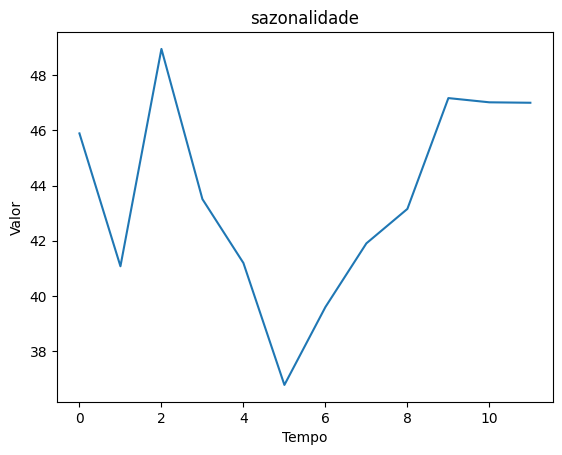

,sazonalidade
sazonalidade,
0,45.892058
1,41.073564
2,48.956011
3,43.508272
4,41.191588
5,36.769922
6,39.593962
7,41.904476
8,43.153582


In [223]:
def calculate_monthly_means(consume_of_cement, subject):
    df = pd.DataFrame({subject: consume_of_cement[:train_split]})
    df['sazonalidade'] = df.index % 12
    monthly_means = df.groupby('sazonalidade')[subject].mean()
    result_df = pd.DataFrame({'sazonalidade': monthly_means})

    return result_df

media_df = calculate_monthly_means(data[subject], subject)
plot_columns(media_df)
media_df

In [224]:
def fill_original_df_with_monthly_means(df_og, media_df):
    monthly_means = media_df['sazonalidade'].tolist()
    df_og['sazonalidade'] = [monthly_means[i % 12] for i in range(len(df_og))]
    return df_og

data = fill_original_df_with_monthly_means(data, media_df)
data = data[[col for col in data.columns if col != subject] + [subject]] #Seta consumo (target) para a coluna final
data

,Unnamed: 0,Alagoas - IDH,Alagoas - Depósito Poupança (R$),Alagoas - IDH Longevidade,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Year,Alagoas - value,Alagoas - IDH Renda,Alagoas- custo m2 (R$),Alagoas - Desemprego,Alagoas - Produção de Cimento (t),Alagoas - PIB - Estadual,Alagoas - PIB - Construção Civil,Alagoas - PIB - Per Capita,Alagoas - PIB - Preços de Mercado,Alagoas - IDH Educacao,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),sazonalidade,Alagoas - Consumo de Cimento (t)
0,2003-1,0.635160,1.594356e+06,0.728082,1.733015,1004.406322,2909.761327,26.020931,21.071712,75.811353,2.973119,2002.694978,0.294434,0.587982,11196.703600,8.765721,30.779440,2.590528e+07,1.303625e+06,7.576443,2.359888e+07,0.574004,384683.093871,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498,45.892058,30.109
1,2003-2,0.635571,1.598004e+06,0.728532,1.732242,1004.408335,2909.761327,26.019480,21.071203,75.813948,2.972700,2002.726142,0.296211,0.588354,11284.186677,8.760196,30.599132,2.593685e+07,1.305020e+06,7.578654,2.360861e+07,0.574517,385266.203928,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389,41.073564,27.684
2,2003-3,0.635982,1.601652e+06,0.728982,1.731790,1004.409509,2909.761327,26.018633,21.070905,75.815461,2.972455,2002.744322,0.297521,0.588725,11367.266677,8.754671,30.545910,2.596843e+07,1.306414e+06,7.580866,2.361833e+07,0.575030,385305.059560,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184,48.956011,26.534
3,2003-4,0.636393,1.605299e+06,0.729432,1.731742,1004.409635,2909.761327,26.018542,21.070874,75.815623,2.972429,2002.746270,0.298766,0.589097,11444.094177,8.749145,30.377624,2.600000e+07,1.307809e+06,7.583078,2.362806e+07,0.575544,385752.052697,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287,43.508272,25.109
4,2003-5,0.636804,1.608947e+06,0.729882,1.752976,1004.066871,2728.142601,26.084558,21.206030,76.090381,2.928113,2002.886466,0.299945,0.589469,11519.250729,8.743620,30.464900,2.603157e+07,1.309203e+06,7.585289,2.363779e+07,0.576057,387164.022451,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538,41.191588,25.171
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,2023-5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34203.746404,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41.191588,NaN
245,2023-6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34166.160992,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36.769922,NaN
246,2023-7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34117.245244,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39.593962,NaN
247,2023-8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34053.559120,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41.904476,NaN


In [225]:
# Shift para prever futuro e não presente
target_data = data[subject].shift(-24)
target_data

0      29.095
1      25.241
2      29.040
3      25.685
4      21.197
        ...  
244       NaN
245       NaN
246       NaN
247       NaN
248       NaN
Name: Alagoas - Consumo de Cimento (t), Length: 249, dtype: float64

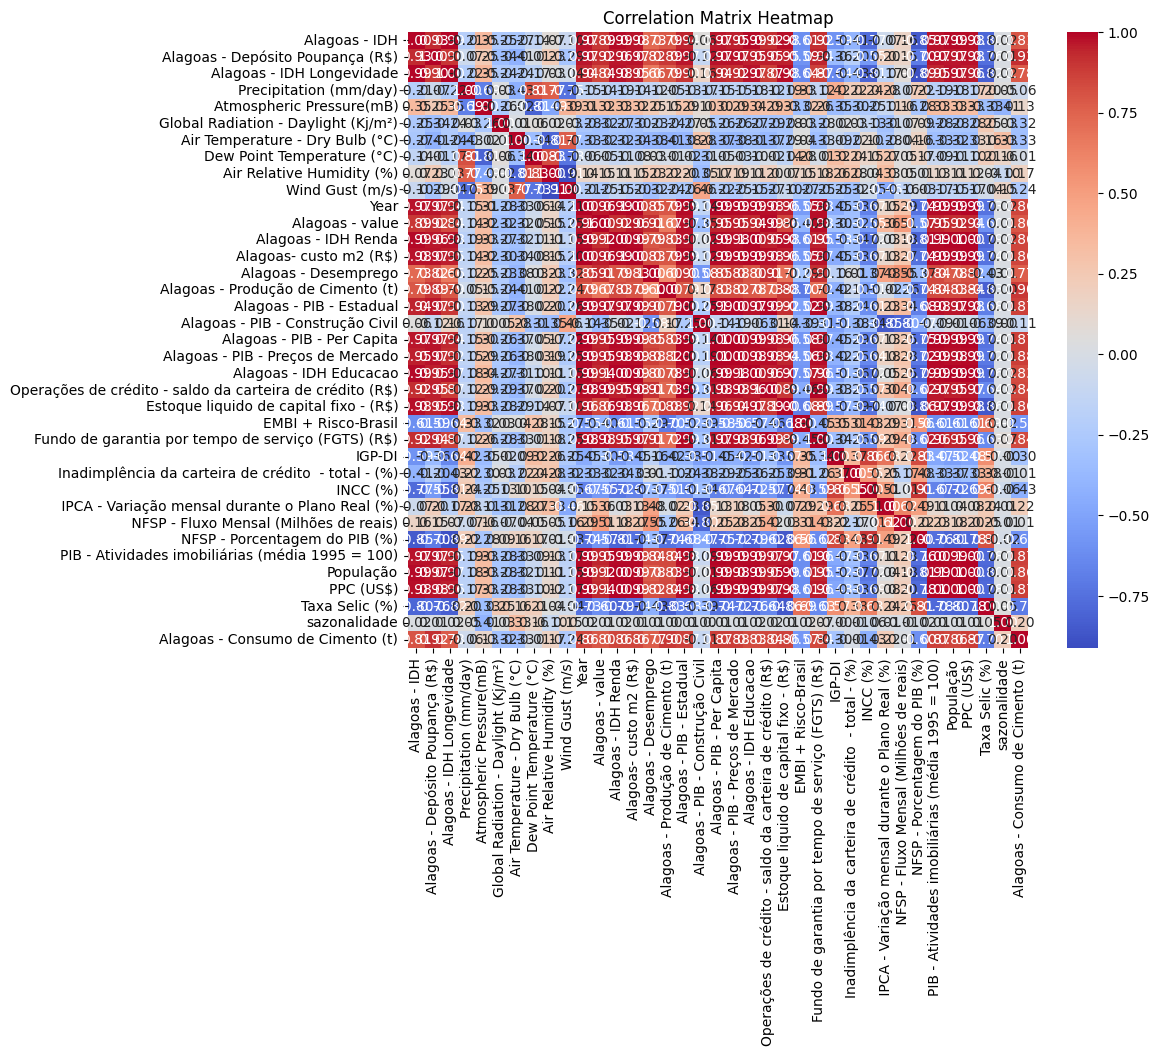

In [226]:
plot_data = data.iloc[:split_index + 1,1:]
plot_correlation_matrix(plot_data)

In [227]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

safe_data = data.iloc[:split_index + 1,1:-1]

def calculate_vif(dataframe):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = dataframe.columns
    vif_data["VIF"] = [variance_inflation_factor(dataframe.values, i) for i in range(dataframe.shape[1])]
    return vif_data

def remove_high_vif_columns(dataframe, threshold=1000):
    i=0
    while True:
        vif_result = calculate_vif(dataframe)
        high_vif_column = vif_result.loc[vif_result["VIF"].idxmax()]["Feature"]
        
        if vif_result["VIF"].max() <= threshold:
            print(f"Num columns removed: {i}")
            return dataframe
        i += 1
        dataframe = dataframe.drop(high_vif_column, axis=1)

In [228]:
safe_data = data.iloc[:split_index + 1,1:-1]
vif_info = calculate_vif(safe_data)
vif_info

,Feature,VIF
0,Alagoas - IDH,4.827501e+10
1,Alagoas - Depósito Poupança (R$),1.253431e+05
2,Alagoas - IDH Longevidade,1.263110e+10
3,Precipitation (mm/day),2.208675e+02
4,Atmospheric Pressure(mB),7.709597e+01
5,Global Radiation - Daylight (Kj/m²),2.750965e+01
6,Air Temperature - Dry Bulb (°C),1.026934e+04
7,Dew Point Temperature (°C),1.253763e+04
8,Air Relative Humidity (%),2.882674e+04
9,Wind Gust (m/s),6.930508e+01


In [229]:
data =data.drop(['Air Temperature - Dry Bulb (°C)',
                 'Precipitation (mm/day)',
                 'Global Radiation - Daylight (Kj/m²)', 
                 'Air Relative Humidity (%)'], axis=1)
data = remove_high_vif_columns(safe_data, 10000000)
data

Num columns removed: 8


,Alagoas - Depósito Poupança (R$),Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Alagoas - value,Alagoas- custo m2 (R$),Alagoas - Desemprego,Alagoas - Produção de Cimento (t),Alagoas - PIB - Estadual,Alagoas - PIB - Construção Civil,Alagoas - IDH Educacao,Operações de crédito - saldo da carteira de crédito (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),PPC (US$),Taxa Selic (%),sazonalidade
0,1.594356e+06,1.733015,1004.406322,2909.761327,26.020931,21.071712,75.811353,2.973119,0.294434,11196.703600,8.765721,30.779440,2.590528e+07,1.303625e+06,0.574004,3.846831e+05,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,169.247665,1.611498,45.892058
1,1.598004e+06,1.732242,1004.408335,2909.761327,26.019480,21.071203,75.813948,2.972700,0.296211,11284.186677,8.760196,30.599132,2.593685e+07,1.305020e+06,0.574517,3.852662e+05,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,170.176810,1.450389,41.073564
2,1.601652e+06,1.731790,1004.409509,2909.761327,26.018633,21.070905,75.815461,2.972455,0.297521,11367.266677,8.754671,30.545910,2.596843e+07,1.306414e+06,0.575030,3.853051e+05,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,171.135713,1.870184,48.956011
3,1.605299e+06,1.731742,1004.409635,2909.761327,26.018542,21.070874,75.815623,2.972429,0.298766,11444.094177,8.749145,30.377624,2.600000e+07,1.307809e+06,0.575544,3.857521e+05,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,172.116904,1.355287,43.508272
4,1.608947e+06,1.752976,1004.066871,2728.142601,26.084558,21.206030,76.090381,2.928113,0.299945,11519.250729,8.743620,30.464900,2.603157e+07,1.309203e+06,0.576057,3.871640e+05,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,173.072271,1.585538,41.191588
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151,3.399586e+06,1.166607,1006.467453,1519.825322,24.858424,20.487881,77.874236,2.705995,0.487547,21316.554338,14.727807,42.188390,3.119068e+07,1.308588e+06,0.636539,3.143856e+06,336.843217,9.124085e+06,0.471500,3.103302,0.501878,0.527374,-1005.696691,2.438647,192.698092,390.589413,1.078474,41.904476
152,3.382397e+06,1.097334,1006.085503,1579.596298,25.184336,20.620947,77.078666,2.870518,0.486644,21403.309418,14.737570,40.900731,3.120704e+07,1.308271e+06,0.637840,3.159665e+06,345.939329,9.111628e+06,0.475422,3.177535,0.489257,0.525404,-1039.159506,2.375528,192.754385,391.798431,0.962516,43.153582
153,3.365208e+06,1.287540,1005.533688,1597.670942,25.539440,20.918415,76.874955,2.988823,0.485656,21488.713372,14.747333,39.617170,3.122341e+07,1.307955e+06,0.639141,3.177292e+06,356.198303,9.630300e+06,0.447600,3.254167,0.489071,0.522000,-1243.715598,2.307250,192.810678,393.032398,1.138989,47.172595
154,3.348018e+06,1.269876,1005.079479,1623.154863,25.886915,21.221704,76.714663,2.988992,0.484585,21579.381309,14.757097,38.338629,3.123978e+07,1.307638e+06,0.640442,3.192250e+06,363.318059,1.020613e+07,0.426394,3.330340,0.486059,0.509714,-1329.246736,2.242645,192.715004,394.326420,1.038436,47.019581


In [230]:
input_data = data.iloc[:split_index + 1,1:-1]
# mean = np.mean(input_data, axis=0)
# stddev =  np.std(input_data, axis=0)
# input_data = ((input_data - mean) /stddev)
scaler=MinMaxScaler()
scaled_data = scaler.fit_transform(input_data)
input_data = pd.DataFrame(scaled_data, columns=input_data.columns)
input_data

,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Alagoas - value,Alagoas- custo m2 (R$),Alagoas - Desemprego,Alagoas - Produção de Cimento (t),Alagoas - PIB - Estadual,Alagoas - PIB - Construção Civil,Alagoas - IDH Educacao,Operações de crédito - saldo da carteira de crédito (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),PPC (US$),Taxa Selic (%)
0,0.600202,0.337742,0.122851,0.447062,0.678883,0.767231,0.324019,0.000000,0.000000,0.038280,0.018761,0.000000,0.000000,0.000000,0.000000,0.108706,0.016690,1.000000,0.912229,1.000000,1.000000,0.543630,1.000000,0.000000,0.000000,0.807549
1,0.599857,0.338094,0.122851,0.446694,0.678780,0.767319,0.323833,0.009068,0.008354,0.037395,0.013083,0.005900,0.020258,0.007576,0.000207,0.058377,0.005415,0.934664,0.910339,0.961590,0.898644,0.544990,0.965719,0.001830,0.004103,0.687691
2,0.599656,0.338299,0.122851,0.446479,0.678720,0.767369,0.323725,0.015755,0.016288,0.036509,0.011407,0.011801,0.040515,0.015153,0.000221,0.100305,0.001062,0.903684,0.909866,0.936241,0.836703,0.532585,0.927412,0.003660,0.008337,1.000000
3,0.599634,0.338321,0.122851,0.446456,0.678714,0.767375,0.323714,0.022114,0.023624,0.035624,0.006108,0.017701,0.060773,0.022729,0.000380,0.211591,0.000000,0.854353,0.909131,0.911951,0.809101,0.504220,0.885588,0.005490,0.012670,0.616940
4,0.609114,0.278485,0.113698,0.463207,0.705927,0.776616,0.304094,0.028129,0.030802,0.034739,0.008856,0.023601,0.081031,0.030306,0.000881,0.358835,0.002490,0.819481,0.905479,0.963424,0.772577,0.515509,0.838034,0.007747,0.016889,0.788236
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151,0.347329,0.697551,0.052806,0.152076,0.561330,0.836614,0.205758,0.985800,0.966391,0.993741,0.378032,0.987765,0.072086,0.923166,0.980090,0.341211,0.837927,0.143160,0.305639,0.047659,0.409150,0.997036,0.057396,0.993627,0.977394,0.411003
152,0.316402,0.630875,0.055818,0.234776,0.588123,0.809856,0.278596,0.981190,0.974676,0.995306,0.337483,0.990824,0.067489,0.942375,0.985706,0.361289,0.836471,0.149108,0.387048,0.021964,0.403230,0.993528,0.050845,0.994471,0.982733,0.324736
153,0.401320,0.534545,0.056729,0.324884,0.648017,0.803004,0.330971,0.976146,0.982831,0.996871,0.297063,0.993883,0.062892,0.961583,0.991968,0.383934,0.897087,0.106917,0.471089,0.021585,0.393004,0.972085,0.043758,0.995316,0.988182,0.456024
154,0.393434,0.455255,0.058014,0.413056,0.709083,0.797613,0.331046,0.970678,0.991490,0.998435,0.256802,0.996941,0.058294,0.980792,0.997280,0.399650,0.964383,0.074759,0.554626,0.015452,0.356091,0.963119,0.037052,0.993880,0.993896,0.381217


In [231]:
# input para treinamento
train_input = input_data.iloc[start_index:train_split]
train_input

,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Alagoas - value,Alagoas- custo m2 (R$),Alagoas - Desemprego,Alagoas - Produção de Cimento (t),Alagoas - PIB - Estadual,Alagoas - PIB - Construção Civil,Alagoas - IDH Educacao,Operações de crédito - saldo da carteira de crédito (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),PPC (US$),Taxa Selic (%)
0,0.600202,0.337742,0.122851,0.447062,0.678883,0.767231,0.324019,0.000000,0.000000,0.038280,0.018761,0.000000,0.000000,0.000000,0.000000,0.108706,0.016690,1.000000,0.912229,1.000000,1.000000,0.543630,1.000000,0.000000,0.000000,0.807549
1,0.599857,0.338094,0.122851,0.446694,0.678780,0.767319,0.323833,0.009068,0.008354,0.037395,0.013083,0.005900,0.020258,0.007576,0.000207,0.058377,0.005415,0.934664,0.910339,0.961590,0.898644,0.544990,0.965719,0.001830,0.004103,0.687691
2,0.599656,0.338299,0.122851,0.446479,0.678720,0.767369,0.323725,0.015755,0.016288,0.036509,0.011407,0.011801,0.040515,0.015153,0.000221,0.100305,0.001062,0.903684,0.909866,0.936241,0.836703,0.532585,0.927412,0.003660,0.008337,1.000000
3,0.599634,0.338321,0.122851,0.446456,0.678714,0.767375,0.323714,0.022114,0.023624,0.035624,0.006108,0.017701,0.060773,0.022729,0.000380,0.211591,0.000000,0.854353,0.909131,0.911951,0.809101,0.504220,0.885588,0.005490,0.012670,0.616940
4,0.609114,0.278485,0.113698,0.463207,0.705927,0.776616,0.304094,0.028129,0.030802,0.034739,0.008856,0.023601,0.081031,0.030306,0.000881,0.358835,0.002490,0.819481,0.905479,0.963424,0.772577,0.515509,0.838034,0.007747,0.016889,0.788236
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,0.475623,0.720689,0.048977,0.059918,0.570732,0.894148,0.174400,0.973135,0.865983,0.950053,0.727206,0.937845,0.188468,0.775255,0.881396,0.145335,0.767121,0.369541,0.134802,0.160109,0.756416,0.799973,0.094876,0.999733,0.929945,0.302580
140,0.479954,0.636117,0.051263,0.136064,0.598523,0.870919,0.242637,0.981043,0.874657,0.956601,0.704407,0.943547,0.171628,0.777946,0.891920,0.149790,0.770809,0.373663,0.107661,0.168785,0.755278,0.803815,0.095765,0.999867,0.932690,0.229929
141,0.471278,0.568947,0.054001,0.228956,0.619697,0.834075,0.278655,0.986694,0.883489,0.963148,0.680972,0.949249,0.154788,0.780636,0.904492,0.156217,0.823469,0.383080,0.063009,0.169823,0.745299,0.692895,0.095412,1.000000,0.935504,0.334488
142,0.475153,0.483375,0.056279,0.321245,0.650098,0.804191,0.290521,0.991077,0.892224,0.969695,0.656882,0.954951,0.137947,0.783326,0.916359,0.164797,0.886163,0.372850,0.017943,0.168006,0.739572,0.764133,0.094477,0.997032,0.938403,0.291661


In [232]:
# Alvo para treinamento
train_target = target_data.iloc[start_index:train_split]
train_target

0      29.095000
1      25.241000
2      29.040000
3      25.685000
4      21.197000
         ...    
139    38.613951
140    39.225390
141    42.641386
142    41.575264
143    38.999500
Name: Alagoas - Consumo de Cimento (t), Length: 144, dtype: float64

In [233]:
def create_batches(t_input, t_target, window_size, start_from):
    
    X_batches = []
    y_batches = []

    train_input_values = t_input.values 

    for i in range(len(t_input) - window_size):
        
        X_window = train_input_values[i:i+window_size, :]
        y_target = t_target[start_from+i+window_size]

        X_batches.append(X_window)
        y_batches.append(y_target)

    return np.array(X_batches), np.array(y_batches)

In [234]:
reshaped_train, reshaped_target = create_batches(train_input, 
                                                 train_target, 
                                                 window_size, 
                                                 start_index)
reshaped_train.shape

(108, 36, 26)

In [235]:
# input para treinamento
test_input = input_data.iloc[train_split - window_size : split_index + 1]
test_input

,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Alagoas - value,Alagoas- custo m2 (R$),Alagoas - Desemprego,Alagoas - Produção de Cimento (t),Alagoas - PIB - Estadual,Alagoas - PIB - Construção Civil,Alagoas - IDH Educacao,Operações de crédito - saldo da carteira de crédito (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),PPC (US$),Taxa Selic (%)
108,0.605121,0.265250,0.020638,0.361178,0.676213,0.800277,0.243847,0.490167,0.697250,0.708098,0.920471,0.710123,0.667200,0.658231,0.584672,0.046476,0.576729,0.241213,0.894461,0.269958,0.246811,0.011842,0.021268,0.788736,0.794730,0.126286
109,0.539492,0.295808,0.015291,0.360808,0.672911,0.798111,0.181695,0.498835,0.701328,0.716545,0.930868,0.718425,0.653159,0.661470,0.592860,0.049796,0.547631,0.257717,0.933771,0.247038,0.255042,0.061730,0.022371,0.801322,0.800825,0.136300
110,0.556284,0.383254,0.006862,0.300756,0.666916,0.828838,0.110754,0.505484,0.705480,0.724992,0.943359,0.726728,0.639119,0.664709,0.603045,0.050154,0.547834,0.301698,0.961400,0.246383,0.284608,0.066764,0.024066,0.813907,0.806817,0.198981
111,0.482454,0.487429,0.004988,0.204615,0.628908,0.856355,0.062943,0.518472,0.709581,0.733440,0.945380,0.735030,0.625078,0.667947,0.613555,0.048907,0.541336,0.299812,0.983561,0.261807,0.314835,0.043925,0.025253,0.826493,0.812425,0.124912
112,0.436455,0.650554,0.009564,0.141592,0.568916,0.845338,0.115306,0.534297,0.713463,0.741887,0.955053,0.743333,0.611037,0.671186,0.623825,0.044925,0.547192,0.255504,0.984745,0.316206,0.306260,0.095032,0.028261,0.839666,0.818016,0.032369
113,0.394853,0.773361,0.018220,0.060028,0.507342,0.845465,0.130554,0.551458,0.717303,0.750334,0.959998,0.751635,0.596996,0.674425,0.633509,0.039367,0.555211,0.207948,0.987221,0.266153,0.311235,0.101029,0.031624,0.852839,0.823761,0.039834
114,0.333365,0.795639,0.026110,0.040286,0.460004,0.820499,0.192493,0.568390,0.720859,0.758781,0.965254,0.759938,0.582955,0.677664,0.642425,0.033811,0.557537,0.169207,0.990146,0.267539,0.309980,0.105226,0.034133,0.866013,0.829544,0.042221
115,0.265433,0.729314,0.038482,0.102093,0.453155,0.780218,0.307346,0.585613,0.724355,0.767228,0.968292,0.768241,0.568914,0.680902,0.652070,0.026160,0.563561,0.122054,1.000000,0.243993,0.301380,0.132974,0.034686,0.878234,0.835366,0.092363
116,0.257406,0.590237,0.047790,0.159028,0.485106,0.773579,0.327567,0.602071,0.727614,0.775675,0.976630,0.776543,0.554873,0.684141,0.662246,0.018514,0.562394,0.079036,0.985009,0.240073,0.312886,0.163856,0.036283,0.890455,0.840978,0.158579
117,0.269133,0.449197,0.053777,0.271751,0.551256,0.759163,0.405285,0.618773,0.731049,0.784122,0.985271,0.784846,0.540832,0.687380,0.675009,0.010641,0.609785,0.065481,0.946695,0.238489,0.304865,0.176276,0.036400,0.902676,0.846397,0.091050


In [236]:
reshaped_test, reshaped_test_target = create_batches(test_input, 
                                                     target_data, 
                                                     window_size, 
                                                     train_split - window_size)
reshaped_test.shape 

(12, 36, 26)

In [237]:
def validation_splitter(arr, div_factor, add_factor=0):
    split_factor = len(arr) // div_factor
    positions_to_drop_index = []
    positions_to_drop = []
    for i in range(split_factor):
        pos = len(arr) - (i * div_factor + 1)
        positions_to_drop_index.append(pos)
        positions_to_drop.append(pos + add_factor)
    
    arr_droped = arr[positions_to_drop]
    arr_result = np.delete(arr, positions_to_drop_index, axis=0)
    
    return arr_result, arr_droped

In [238]:
# Rede Neural Recorrente com optmizador Estocástico
def lstm_model(train_input, train_target, want_verbose=1, seed=0):
    if seed != 0:
        random.seed(seed)
        np.random.seed(seed)
        tf.random.set_seed(seed)
    # Aṕos 500 epochs sem grandes melhoras no val_loss, interrompe.
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                      patience=500, 
                                                      verbose=want_verbose, 
                                                      restore_best_weights=True,
                                                      start_from_epoch=500)
    # Método estocástico e learning rate=0.005
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.005)
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(36, activation='tanh', 
                            return_sequences=True, 
                            kernel_regularizer=tf.keras.regularizers.l2(0.01),  
                            input_shape=(reshaped_train.shape[1], reshaped_train.shape[2])),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.LSTM(144, activation='tanh', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer=optimizer,
                  loss='mean_squared_error')    
    history = model.fit(train_input, 
                        train_target, 
                        epochs=10000,
                        validation_split=0.07,
                        callbacks=[early_stopping], 
                        verbose=want_verbose)
    return model, history

In [239]:
def get_a_good_seed(train_input, train_target, test_input, test_target):

    random_seeds = [random.randint(0, 2**32 - 1) for _ in range(10)]
    print(random_seeds)

    best_loss = float('inf')
    winner_seed = None
    i = 0
    for seed in random_seeds:
        print(f"\n\nStep: {i} ___________________________________________")
        i += 1

        model, history = lstm_model(train_input, train_target, want_verbose=0, seed=seed)
        current_loss = min(history.history['val_loss'][500:])
        print(f"val_loss: {current_loss}")

        if current_loss < best_loss:
            best_loss = current_loss
            winner_seed = seed
            print(f"winner_seed: {winner_seed}")
            if winner_seed == 0.0:
                return winner_seed

    return winner_seed

In [240]:
winner_seed = get_a_good_seed(reshaped_train, reshaped_target, reshaped_test, reshaped_test_target)
print(f"\n\nfinal_seed: {winner_seed}")

[2650701352, 3996965656, 362221341, 2807945021, 3923816040, 590152062, 163566010, 3986825415, 1563891383, 3871509121]


Step: 0 ___________________________________________
val_loss: 6.825902462005615
winner_seed: 2650701352


Step: 1 ___________________________________________
val_loss: 7.071632385253906


Step: 2 ___________________________________________
val_loss: 4.344516754150391
winner_seed: 362221341


Step: 3 ___________________________________________
val_loss: 5.919467449188232


Step: 4 ___________________________________________
val_loss: 13.278176307678223


Step: 5 ___________________________________________
val_loss: 5.578620910644531


Step: 6 ___________________________________________
val_loss: 5.6049604415893555


Step: 7 ___________________________________________
val_loss: 7.440488815307617


Step: 8 ___________________________________________
val_loss: 7.13360595703125


Step: 9 ___________________________________________
val_loss: 120.4856948852539


final_seed: 

In [241]:
trained_model, history = lstm_model(reshaped_train, 
                                    reshaped_target, 
                                    want_verbose=1, 
                                    seed=winner_seed)

Epoch 1/10000
4/4 [==============================] - 2s 118ms/step - loss: 2550.5852 - val_loss: 281.5840
Epoch 2/10000
4/4 [==============================] - 0s 8ms/step - loss: 173.3660 - val_loss: 672.4311
Epoch 3/10000
4/4 [==============================] - 0s 7ms/step - loss: 217.9915 - val_loss: 26.7723
Epoch 4/10000
4/4 [==============================] - 0s 7ms/step - loss: 212.3793 - val_loss: 632.5549
Epoch 5/10000
4/4 [==============================] - 0s 7ms/step - loss: 192.2456 - val_loss: 378.7621
Epoch 6/10000
4/4 [==============================] - 0s 7ms/step - loss: 213.8423 - val_loss: 767.0847
Epoch 7/10000
4/4 [==============================] - 0s 7ms/step - loss: 205.3460 - val_loss: 910.1917
Epoch 8/10000
4/4 [==============================] - 0s 7ms/step - loss: 268.1425 - val_loss: 430.9076
Epoch 9/10000
4/4 [==============================] - 0s 7ms/step - loss: 187.9517 - val_loss: 145.9756
Epoch 10/10000
4/4 [==============================] - 0s 7ms/step - los

4/4 [==============================] - 0s 7ms/step - loss: 76.5015 - val_loss: 179.8937
Epoch 81/10000
4/4 [==============================] - 0s 7ms/step - loss: 80.3043 - val_loss: 547.1135
Epoch 82/10000
4/4 [==============================] - 0s 7ms/step - loss: 59.1896 - val_loss: 389.9073
Epoch 83/10000
4/4 [==============================] - 0s 7ms/step - loss: 72.9114 - val_loss: 464.2306
Epoch 84/10000
4/4 [==============================] - 0s 7ms/step - loss: 73.6741 - val_loss: 243.7694
Epoch 85/10000
4/4 [==============================] - 0s 7ms/step - loss: 59.5569 - val_loss: 595.0610
Epoch 86/10000
4/4 [==============================] - 0s 8ms/step - loss: 64.4789 - val_loss: 521.7932
Epoch 87/10000
4/4 [==============================] - 0s 7ms/step - loss: 63.5556 - val_loss: 220.9711
Epoch 88/10000
4/4 [==============================] - 0s 8ms/step - loss: 61.8346 - val_loss: 124.8623
Epoch 89/10000
4/4 [==============================] - 0s 7ms/step - loss: 80.1196 - val_

4/4 [==============================] - 0s 8ms/step - loss: 66.9726 - val_loss: 179.5574
Epoch 160/10000
4/4 [==============================] - 0s 7ms/step - loss: 48.7679 - val_loss: 119.6431
Epoch 161/10000
4/4 [==============================] - 0s 7ms/step - loss: 46.1588 - val_loss: 97.3472
Epoch 162/10000
4/4 [==============================] - 0s 7ms/step - loss: 35.2206 - val_loss: 62.9449
Epoch 163/10000
4/4 [==============================] - 0s 7ms/step - loss: 37.7895 - val_loss: 18.5665
Epoch 164/10000
4/4 [==============================] - 0s 7ms/step - loss: 37.6815 - val_loss: 140.5391
Epoch 165/10000
4/4 [==============================] - 0s 7ms/step - loss: 43.7534 - val_loss: 73.2015
Epoch 166/10000
4/4 [==============================] - 0s 8ms/step - loss: 35.1831 - val_loss: 48.1986
Epoch 167/10000
4/4 [==============================] - 0s 7ms/step - loss: 35.0751 - val_loss: 44.6783
Epoch 168/10000
4/4 [==============================] - 0s 7ms/step - loss: 35.6056 - v

4/4 [==============================] - 0s 14ms/step - loss: 43.4503 - val_loss: 10.7253
Epoch 239/10000
4/4 [==============================] - 0s 10ms/step - loss: 41.2853 - val_loss: 81.7818
Epoch 240/10000
4/4 [==============================] - 0s 9ms/step - loss: 48.3208 - val_loss: 25.7361
Epoch 241/10000
4/4 [==============================] - 0s 8ms/step - loss: 37.1306 - val_loss: 74.4847
Epoch 242/10000
4/4 [==============================] - 0s 9ms/step - loss: 44.3026 - val_loss: 16.4130
Epoch 243/10000
4/4 [==============================] - 0s 8ms/step - loss: 37.4992 - val_loss: 67.4617
Epoch 244/10000
4/4 [==============================] - 0s 9ms/step - loss: 36.7703 - val_loss: 13.3537
Epoch 245/10000
4/4 [==============================] - 0s 11ms/step - loss: 40.4937 - val_loss: 60.6673
Epoch 246/10000
4/4 [==============================] - 0s 12ms/step - loss: 42.4776 - val_loss: 37.0471
Epoch 247/10000
4/4 [==============================] - 0s 10ms/step - loss: 35.4957 -

4/4 [==============================] - 0s 10ms/step - loss: 40.8402 - val_loss: 23.2787
Epoch 318/10000
4/4 [==============================] - 0s 10ms/step - loss: 35.5560 - val_loss: 56.0417
Epoch 319/10000
4/4 [==============================] - 0s 10ms/step - loss: 35.6926 - val_loss: 22.4377
Epoch 320/10000
4/4 [==============================] - 0s 10ms/step - loss: 34.4504 - val_loss: 28.4505
Epoch 321/10000
4/4 [==============================] - 0s 10ms/step - loss: 33.3889 - val_loss: 39.2869
Epoch 322/10000
4/4 [==============================] - 0s 10ms/step - loss: 36.0907 - val_loss: 14.7800
Epoch 323/10000
4/4 [==============================] - 0s 10ms/step - loss: 40.8468 - val_loss: 63.9437
Epoch 324/10000
4/4 [==============================] - 0s 9ms/step - loss: 38.3296 - val_loss: 68.4955
Epoch 325/10000
4/4 [==============================] - 0s 10ms/step - loss: 35.9789 - val_loss: 19.9511
Epoch 326/10000
4/4 [==============================] - 0s 9ms/step - loss: 38.084

4/4 [==============================] - 0s 13ms/step - loss: 46.6353 - val_loss: 37.0995
Epoch 397/10000
4/4 [==============================] - 0s 12ms/step - loss: 32.8827 - val_loss: 89.5079
Epoch 398/10000
4/4 [==============================] - 0s 12ms/step - loss: 37.6417 - val_loss: 64.4679
Epoch 399/10000
4/4 [==============================] - 0s 12ms/step - loss: 35.0185 - val_loss: 61.2157
Epoch 400/10000
4/4 [==============================] - 0s 12ms/step - loss: 34.4763 - val_loss: 11.4078
Epoch 401/10000
4/4 [==============================] - 0s 11ms/step - loss: 47.8704 - val_loss: 20.8131
Epoch 402/10000
4/4 [==============================] - 0s 10ms/step - loss: 33.2813 - val_loss: 57.7910
Epoch 403/10000
4/4 [==============================] - 0s 9ms/step - loss: 40.1013 - val_loss: 13.4755
Epoch 404/10000
4/4 [==============================] - 0s 9ms/step - loss: 34.4146 - val_loss: 29.1929
Epoch 405/10000
4/4 [==============================] - 0s 10ms/step - loss: 33.538

Epoch 475/10000
4/4 [==============================] - 0s 12ms/step - loss: 33.4032 - val_loss: 26.3860
Epoch 476/10000
4/4 [==============================] - 0s 12ms/step - loss: 32.8093 - val_loss: 94.6325
Epoch 477/10000
4/4 [==============================] - 0s 11ms/step - loss: 35.2047 - val_loss: 13.4980
Epoch 478/10000
4/4 [==============================] - 0s 12ms/step - loss: 38.7038 - val_loss: 11.0859
Epoch 479/10000
4/4 [==============================] - 0s 11ms/step - loss: 44.6688 - val_loss: 17.0786
Epoch 480/10000
4/4 [==============================] - 0s 11ms/step - loss: 31.2348 - val_loss: 32.2609
Epoch 481/10000
4/4 [==============================] - 0s 11ms/step - loss: 32.2445 - val_loss: 79.1311
Epoch 482/10000
4/4 [==============================] - 0s 10ms/step - loss: 40.2528 - val_loss: 25.5752
Epoch 483/10000
4/4 [==============================] - 0s 11ms/step - loss: 34.1181 - val_loss: 41.7046
Epoch 484/10000
4/4 [==============================] - 0s 12ms/s

Epoch 554/10000
4/4 [==============================] - 0s 12ms/step - loss: 29.2358 - val_loss: 19.8509
Epoch 555/10000
4/4 [==============================] - 0s 11ms/step - loss: 29.3566 - val_loss: 15.0311
Epoch 556/10000
4/4 [==============================] - 0s 12ms/step - loss: 31.9013 - val_loss: 11.6683
Epoch 557/10000
4/4 [==============================] - 0s 12ms/step - loss: 38.7120 - val_loss: 43.7611
Epoch 558/10000
4/4 [==============================] - 0s 12ms/step - loss: 30.5639 - val_loss: 32.2697
Epoch 559/10000
4/4 [==============================] - 0s 11ms/step - loss: 30.8745 - val_loss: 32.9183
Epoch 560/10000
4/4 [==============================] - 0s 11ms/step - loss: 31.6144 - val_loss: 70.4554
Epoch 561/10000
4/4 [==============================] - 0s 11ms/step - loss: 39.3195 - val_loss: 35.6773
Epoch 562/10000
4/4 [==============================] - 0s 11ms/step - loss: 27.9412 - val_loss: 34.7525
Epoch 563/10000
4/4 [==============================] - 0s 11ms/s

4/4 [==============================] - 0s 12ms/step - loss: 28.6697 - val_loss: 29.8039
Epoch 633/10000
4/4 [==============================] - 0s 11ms/step - loss: 31.2796 - val_loss: 24.3963
Epoch 634/10000
4/4 [==============================] - 0s 12ms/step - loss: 29.9507 - val_loss: 44.2515
Epoch 635/10000
4/4 [==============================] - 0s 14ms/step - loss: 33.7838 - val_loss: 107.3453
Epoch 636/10000
4/4 [==============================] - 0s 12ms/step - loss: 35.9568 - val_loss: 53.9138
Epoch 637/10000
4/4 [==============================] - 0s 13ms/step - loss: 31.7415 - val_loss: 16.4154
Epoch 638/10000
4/4 [==============================] - 0s 12ms/step - loss: 28.6966 - val_loss: 17.6042
Epoch 639/10000
4/4 [==============================] - 0s 11ms/step - loss: 28.2593 - val_loss: 43.5278
Epoch 640/10000
4/4 [==============================] - 0s 11ms/step - loss: 32.2985 - val_loss: 39.2523
Epoch 641/10000
4/4 [==============================] - 0s 11ms/step - loss: 31.

Epoch 711/10000
4/4 [==============================] - 0s 12ms/step - loss: 26.7663 - val_loss: 31.9040
Epoch 712/10000
4/4 [==============================] - 0s 11ms/step - loss: 27.5193 - val_loss: 10.0367
Epoch 713/10000
4/4 [==============================] - 0s 11ms/step - loss: 30.8588 - val_loss: 41.8644
Epoch 714/10000
4/4 [==============================] - 0s 12ms/step - loss: 27.4083 - val_loss: 27.1357
Epoch 715/10000
4/4 [==============================] - 0s 12ms/step - loss: 26.7042 - val_loss: 9.1973
Epoch 716/10000
4/4 [==============================] - 0s 12ms/step - loss: 36.6409 - val_loss: 50.3945
Epoch 717/10000
4/4 [==============================] - 0s 11ms/step - loss: 34.5751 - val_loss: 15.7868
Epoch 718/10000
4/4 [==============================] - 0s 11ms/step - loss: 28.7516 - val_loss: 42.8945
Epoch 719/10000
4/4 [==============================] - 0s 11ms/step - loss: 26.6640 - val_loss: 24.8966
Epoch 720/10000
4/4 [==============================] - 0s 11ms/st

Epoch 790/10000
4/4 [==============================] - 0s 12ms/step - loss: 30.9665 - val_loss: 32.3345
Epoch 791/10000
4/4 [==============================] - 0s 11ms/step - loss: 25.9278 - val_loss: 34.8023
Epoch 792/10000
4/4 [==============================] - 0s 11ms/step - loss: 25.3590 - val_loss: 57.7569
Epoch 793/10000
4/4 [==============================] - 0s 11ms/step - loss: 29.3577 - val_loss: 39.2896
Epoch 794/10000
4/4 [==============================] - 0s 12ms/step - loss: 27.2715 - val_loss: 37.2329
Epoch 795/10000
4/4 [==============================] - 0s 11ms/step - loss: 25.1992 - val_loss: 14.6101
Epoch 796/10000
4/4 [==============================] - 0s 11ms/step - loss: 25.3649 - val_loss: 14.0839
Epoch 797/10000
4/4 [==============================] - 0s 11ms/step - loss: 25.8420 - val_loss: 59.2119
Epoch 798/10000
4/4 [==============================] - 0s 11ms/step - loss: 28.3352 - val_loss: 29.8031
Epoch 799/10000
4/4 [==============================] - 0s 12ms/s

Epoch 869/10000
4/4 [==============================] - 0s 14ms/step - loss: 31.8769 - val_loss: 13.6665
Epoch 870/10000
4/4 [==============================] - 0s 11ms/step - loss: 21.8924 - val_loss: 36.1338
Epoch 871/10000
4/4 [==============================] - 0s 11ms/step - loss: 24.7906 - val_loss: 12.4338
Epoch 872/10000
4/4 [==============================] - 0s 12ms/step - loss: 57.3379 - val_loss: 45.6188
Epoch 873/10000
4/4 [==============================] - 0s 13ms/step - loss: 32.5181 - val_loss: 23.6623
Epoch 874/10000
4/4 [==============================] - 0s 12ms/step - loss: 26.1212 - val_loss: 14.5764
Epoch 875/10000
4/4 [==============================] - 0s 11ms/step - loss: 24.5932 - val_loss: 12.3239
Epoch 876/10000
4/4 [==============================] - 0s 11ms/step - loss: 22.6682 - val_loss: 66.2434
Epoch 877/10000
4/4 [==============================] - 0s 10ms/step - loss: 38.5804 - val_loss: 23.6363
Epoch 878/10000
4/4 [==============================] - 0s 9ms/st

Epoch 948/10000
4/4 [==============================] - 0s 11ms/step - loss: 18.4827 - val_loss: 18.9104
Epoch 949/10000
4/4 [==============================] - 0s 12ms/step - loss: 17.9167 - val_loss: 20.8577
Epoch 950/10000
4/4 [==============================] - 0s 11ms/step - loss: 21.1893 - val_loss: 23.3696
Epoch 951/10000
4/4 [==============================] - 0s 12ms/step - loss: 20.5486 - val_loss: 11.6282
Epoch 952/10000
4/4 [==============================] - 0s 11ms/step - loss: 24.7993 - val_loss: 28.8829
Epoch 953/10000
4/4 [==============================] - 0s 11ms/step - loss: 18.6162 - val_loss: 88.6527
Epoch 954/10000
4/4 [==============================] - 0s 11ms/step - loss: 35.5005 - val_loss: 14.6296
Epoch 955/10000
4/4 [==============================] - 0s 11ms/step - loss: 22.0649 - val_loss: 44.0536
Epoch 956/10000
4/4 [==============================] - 0s 13ms/step - loss: 22.1072 - val_loss: 24.5133
Epoch 957/10000
4/4 [==============================] - 0s 13ms/s

4/4 [==============================] - 0s 12ms/step - loss: 19.1438 - val_loss: 11.6175
Epoch 1027/10000
4/4 [==============================] - 0s 11ms/step - loss: 23.2183 - val_loss: 8.7265
Epoch 1028/10000
4/4 [==============================] - 0s 11ms/step - loss: 20.5321 - val_loss: 22.6921
Epoch 1029/10000
4/4 [==============================] - 0s 12ms/step - loss: 17.6557 - val_loss: 12.3261
Epoch 1030/10000
4/4 [==============================] - 0s 12ms/step - loss: 20.8332 - val_loss: 17.4423
Epoch 1031/10000
4/4 [==============================] - 0s 12ms/step - loss: 17.9618 - val_loss: 8.9099
Epoch 1032/10000
4/4 [==============================] - 0s 11ms/step - loss: 20.4416 - val_loss: 26.9794
Epoch 1033/10000
4/4 [==============================] - 0s 11ms/step - loss: 19.4284 - val_loss: 36.7463
Epoch 1034/10000
4/4 [==============================] - 0s 11ms/step - loss: 21.9162 - val_loss: 9.3913
Epoch 1035/10000
4/4 [==============================] - 0s 12ms/step - loss

4/4 [==============================] - 0s 11ms/step - loss: 20.1187 - val_loss: 25.0722
Epoch 1105/10000
4/4 [==============================] - 0s 11ms/step - loss: 19.6654 - val_loss: 8.1150
Epoch 1106/10000
4/4 [==============================] - 0s 10ms/step - loss: 22.9671 - val_loss: 12.4641
Epoch 1107/10000
4/4 [==============================] - 0s 11ms/step - loss: 18.5765 - val_loss: 28.5928
Epoch 1108/10000
4/4 [==============================] - 0s 11ms/step - loss: 23.5226 - val_loss: 16.7661
Epoch 1109/10000
4/4 [==============================] - 0s 10ms/step - loss: 18.6163 - val_loss: 10.8672
Epoch 1110/10000
4/4 [==============================] - 0s 11ms/step - loss: 23.4198 - val_loss: 40.7040
Epoch 1111/10000
4/4 [==============================] - 0s 12ms/step - loss: 24.5065 - val_loss: 16.6180
Epoch 1112/10000
4/4 [==============================] - 0s 11ms/step - loss: 17.5085 - val_loss: 28.3752
Epoch 1113/10000
4/4 [==============================] - 0s 11ms/step - lo

4/4 [==============================] - 0s 12ms/step - loss: 16.1105 - val_loss: 10.1609
Epoch 1183/10000
4/4 [==============================] - 0s 12ms/step - loss: 16.3043 - val_loss: 24.6358
Epoch 1184/10000
4/4 [==============================] - 0s 10ms/step - loss: 17.1348 - val_loss: 19.3675
Epoch 1185/10000
4/4 [==============================] - 0s 11ms/step - loss: 16.3792 - val_loss: 13.0650
Epoch 1186/10000
4/4 [==============================] - 0s 12ms/step - loss: 15.5420 - val_loss: 8.3925
Epoch 1187/10000
4/4 [==============================] - 0s 12ms/step - loss: 16.9884 - val_loss: 20.0747
Epoch 1188/10000
4/4 [==============================] - 0s 13ms/step - loss: 16.3485 - val_loss: 10.5423
Epoch 1189/10000
4/4 [==============================] - 0s 12ms/step - loss: 16.9684 - val_loss: 7.3219
Epoch 1190/10000
4/4 [==============================] - 0s 12ms/step - loss: 24.6587 - val_loss: 72.6288
Epoch 1191/10000
4/4 [==============================] - 0s 11ms/step - los

4/4 [==============================] - 0s 11ms/step - loss: 21.2749 - val_loss: 30.7165
Epoch 1261/10000
4/4 [==============================] - 0s 12ms/step - loss: 19.7556 - val_loss: 14.0292
Epoch 1262/10000
4/4 [==============================] - 0s 11ms/step - loss: 17.1425 - val_loss: 10.0329
Epoch 1263/10000
4/4 [==============================] - 0s 11ms/step - loss: 16.0599 - val_loss: 9.9066
Epoch 1264/10000
4/4 [==============================] - 0s 12ms/step - loss: 15.6615 - val_loss: 7.8524
Epoch 1265/10000
4/4 [==============================] - 0s 12ms/step - loss: 17.6432 - val_loss: 7.1696
Epoch 1266/10000
4/4 [==============================] - 0s 11ms/step - loss: 18.9520 - val_loss: 18.0609
Epoch 1267/10000
4/4 [==============================] - 0s 11ms/step - loss: 16.6964 - val_loss: 22.9565
Epoch 1268/10000
4/4 [==============================] - 0s 12ms/step - loss: 15.4787 - val_loss: 8.8782
Epoch 1269/10000
4/4 [==============================] - 0s 13ms/step - loss:

4/4 [==============================] - 0s 11ms/step - loss: 14.2831 - val_loss: 22.1774
Epoch 1339/10000
4/4 [==============================] - 0s 12ms/step - loss: 16.2833 - val_loss: 11.3884
Epoch 1340/10000
4/4 [==============================] - 0s 10ms/step - loss: 15.9129 - val_loss: 18.1587
Epoch 1341/10000
4/4 [==============================] - 0s 11ms/step - loss: 13.8719 - val_loss: 9.0478
Epoch 1342/10000
4/4 [==============================] - 0s 11ms/step - loss: 14.0749 - val_loss: 14.5678
Epoch 1343/10000
4/4 [==============================] - 0s 11ms/step - loss: 15.1472 - val_loss: 8.7840
Epoch 1344/10000
4/4 [==============================] - 0s 12ms/step - loss: 16.9401 - val_loss: 8.3852
Epoch 1345/10000
4/4 [==============================] - 0s 11ms/step - loss: 16.1033 - val_loss: 12.1795
Epoch 1346/10000
4/4 [==============================] - 0s 11ms/step - loss: 14.6115 - val_loss: 7.6257
Epoch 1347/10000
4/4 [==============================] - 0s 11ms/step - loss:

4/4 [==============================] - 0s 11ms/step - loss: 14.3933 - val_loss: 12.4909
Epoch 1417/10000
4/4 [==============================] - 0s 11ms/step - loss: 14.1041 - val_loss: 9.6547
Epoch 1418/10000
4/4 [==============================] - 0s 11ms/step - loss: 13.4757 - val_loss: 24.7650
Epoch 1419/10000
4/4 [==============================] - 0s 11ms/step - loss: 13.9821 - val_loss: 9.6366
Epoch 1420/10000
4/4 [==============================] - 0s 11ms/step - loss: 13.3302 - val_loss: 11.5564
Epoch 1421/10000
4/4 [==============================] - 0s 11ms/step - loss: 14.0361 - val_loss: 24.2637
Epoch 1422/10000
4/4 [==============================] - 0s 11ms/step - loss: 15.4112 - val_loss: 8.5578
Epoch 1423/10000
4/4 [==============================] - 0s 13ms/step - loss: 21.2841 - val_loss: 8.1780
Epoch 1424/10000
4/4 [==============================] - 0s 13ms/step - loss: 16.5760 - val_loss: 16.9584
Epoch 1425/10000
4/4 [==============================] - 0s 11ms/step - loss:

4/4 [==============================] - 0s 13ms/step - loss: 14.0792 - val_loss: 10.9875
Epoch 1495/10000
4/4 [==============================] - 0s 10ms/step - loss: 14.6206 - val_loss: 11.4914
Epoch 1496/10000
4/4 [==============================] - 0s 11ms/step - loss: 13.5062 - val_loss: 23.0388
Epoch 1497/10000
4/4 [==============================] - 0s 11ms/step - loss: 16.7217 - val_loss: 22.9242
Epoch 1498/10000
4/4 [==============================] - 0s 12ms/step - loss: 13.3743 - val_loss: 6.2625
Epoch 1499/10000
4/4 [==============================] - 0s 11ms/step - loss: 12.8335 - val_loss: 10.0618
Epoch 1500/10000
4/4 [==============================] - 0s 11ms/step - loss: 12.9137 - val_loss: 6.7218
Epoch 1501/10000
4/4 [==============================] - 0s 11ms/step - loss: 13.5217 - val_loss: 8.4692
Epoch 1502/10000
4/4 [==============================] - 0s 12ms/step - loss: 13.5562 - val_loss: 11.6823
Epoch 1503/10000
4/4 [==============================] - 0s 13ms/step - loss

4/4 [==============================] - 0s 11ms/step - loss: 18.6270 - val_loss: 39.0235
Epoch 1573/10000
4/4 [==============================] - 0s 11ms/step - loss: 15.4701 - val_loss: 26.8954
Epoch 1574/10000
4/4 [==============================] - 0s 11ms/step - loss: 14.8053 - val_loss: 21.9697
Epoch 1575/10000
4/4 [==============================] - 0s 11ms/step - loss: 14.3940 - val_loss: 7.5691
Epoch 1576/10000
4/4 [==============================] - 0s 12ms/step - loss: 14.8218 - val_loss: 6.2659
Epoch 1577/10000
4/4 [==============================] - 0s 11ms/step - loss: 14.8520 - val_loss: 13.1948
Epoch 1578/10000
4/4 [==============================] - 0s 11ms/step - loss: 13.6527 - val_loss: 16.8558
Epoch 1579/10000
4/4 [==============================] - 0s 11ms/step - loss: 13.4710 - val_loss: 13.2548
Epoch 1580/10000
4/4 [==============================] - 0s 12ms/step - loss: 17.6301 - val_loss: 8.8255
Epoch 1581/10000
4/4 [==============================] - 0s 12ms/step - loss

4/4 [==============================] - 0s 9ms/step - loss: 15.8051 - val_loss: 13.6232
Epoch 1651/10000
4/4 [==============================] - 0s 9ms/step - loss: 14.0075 - val_loss: 12.4540
Epoch 1652/10000
4/4 [==============================] - 0s 10ms/step - loss: 12.8600 - val_loss: 12.1721
Epoch 1653/10000
4/4 [==============================] - 0s 10ms/step - loss: 17.0010 - val_loss: 6.8916
Epoch 1654/10000
4/4 [==============================] - 0s 10ms/step - loss: 15.2786 - val_loss: 8.3501
Epoch 1655/10000
4/4 [==============================] - 0s 9ms/step - loss: 14.9686 - val_loss: 21.3156
Epoch 1656/10000
4/4 [==============================] - 0s 10ms/step - loss: 15.5063 - val_loss: 13.6989
Epoch 1657/10000
4/4 [==============================] - 0s 10ms/step - loss: 12.3796 - val_loss: 15.2866
Epoch 1658/10000
4/4 [==============================] - 0s 10ms/step - loss: 13.4436 - val_loss: 9.8237
Epoch 1659/10000
4/4 [==============================] - 0s 9ms/step - loss: 13

4/4 [==============================] - 0s 11ms/step - loss: 12.2381 - val_loss: 13.6011
Epoch 1729/10000
4/4 [==============================] - 0s 11ms/step - loss: 12.6957 - val_loss: 6.7392
Epoch 1730/10000
4/4 [==============================] - 0s 12ms/step - loss: 14.0798 - val_loss: 27.8290
Epoch 1731/10000
4/4 [==============================] - 0s 11ms/step - loss: 18.5810 - val_loss: 14.8304
Epoch 1732/10000
4/4 [==============================] - 0s 11ms/step - loss: 14.2032 - val_loss: 17.3768
Epoch 1733/10000
4/4 [==============================] - 0s 12ms/step - loss: 14.1559 - val_loss: 12.1654
Epoch 1734/10000
4/4 [==============================] - 0s 11ms/step - loss: 13.0061 - val_loss: 12.2056
Epoch 1735/10000
4/4 [==============================] - 0s 12ms/step - loss: 12.3146 - val_loss: 13.7671
Epoch 1736/10000
4/4 [==============================] - 0s 12ms/step - loss: 15.5463 - val_loss: 16.9748
Epoch 1737/10000
4/4 [==============================] - 0s 11ms/step - lo

4/4 [==============================] - 0s 11ms/step - loss: 15.2103 - val_loss: 41.2399
Epoch 1807/10000
4/4 [==============================] - 0s 11ms/step - loss: 17.0125 - val_loss: 8.7093
Epoch 1808/10000
4/4 [==============================] - 0s 12ms/step - loss: 13.0305 - val_loss: 7.5340
Epoch 1809/10000
4/4 [==============================] - 0s 11ms/step - loss: 12.9025 - val_loss: 10.2632
Epoch 1810/10000
4/4 [==============================] - 0s 12ms/step - loss: 11.7551 - val_loss: 17.0320
Epoch 1811/10000
4/4 [==============================] - 0s 11ms/step - loss: 11.2821 - val_loss: 20.4322
Epoch 1812/10000
4/4 [==============================] - 0s 11ms/step - loss: 12.3208 - val_loss: 9.5053
Epoch 1813/10000
4/4 [==============================] - 0s 12ms/step - loss: 11.8544 - val_loss: 13.5838
Epoch 1814/10000
4/4 [==============================] - 0s 11ms/step - loss: 11.4915 - val_loss: 16.7861
Epoch 1815/10000
4/4 [==============================] - 0s 11ms/step - loss

4/4 [==============================] - 0s 12ms/step - loss: 11.0491 - val_loss: 7.7636
Epoch 1885/10000
4/4 [==============================] - 0s 12ms/step - loss: 12.8186 - val_loss: 13.6579
Epoch 1886/10000
4/4 [==============================] - 0s 12ms/step - loss: 10.7780 - val_loss: 11.3905
Epoch 1887/10000
4/4 [==============================] - 0s 13ms/step - loss: 11.9068 - val_loss: 20.7993
Epoch 1888/10000
4/4 [==============================] - 0s 12ms/step - loss: 11.0904 - val_loss: 14.9015
Epoch 1889/10000
4/4 [==============================] - 0s 12ms/step - loss: 10.8971 - val_loss: 24.9992
Epoch 1890/10000
4/4 [==============================] - 0s 10ms/step - loss: 15.0328 - val_loss: 16.9264
Epoch 1891/10000
4/4 [==============================] - 0s 12ms/step - loss: 12.1707 - val_loss: 50.7296
Epoch 1892/10000
4/4 [==============================] - 0s 12ms/step - loss: 13.9400 - val_loss: 13.5156
Epoch 1893/10000
4/4 [==============================] - 0s 12ms/step - lo

4/4 [==============================] - 0s 11ms/step - loss: 15.0628 - val_loss: 13.5556
Epoch 1963/10000
4/4 [==============================] - 0s 11ms/step - loss: 11.6654 - val_loss: 17.8852
Epoch 1964/10000
4/4 [==============================] - 0s 11ms/step - loss: 10.8097 - val_loss: 14.2305
Epoch 1965/10000
4/4 [==============================] - 0s 11ms/step - loss: 12.8942 - val_loss: 15.4489
Epoch 1966/10000
4/4 [==============================] - 0s 12ms/step - loss: 11.6816 - val_loss: 18.9726
Epoch 1967/10000
4/4 [==============================] - 0s 14ms/step - loss: 10.7867 - val_loss: 24.8690
Epoch 1968/10000
4/4 [==============================] - 0s 11ms/step - loss: 11.2144 - val_loss: 11.7706
Epoch 1969/10000
4/4 [==============================] - 0s 12ms/step - loss: 10.9717 - val_loss: 7.6340
Epoch 1970/10000
4/4 [==============================] - 0s 11ms/step - loss: 12.3827 - val_loss: 37.2971
Epoch 1971/10000
4/4 [==============================] - 0s 11ms/step - lo

4/4 [==============================] - 0s 12ms/step - loss: 14.1907 - val_loss: 15.1427
Epoch 2041/10000
4/4 [==============================] - 0s 12ms/step - loss: 14.8065 - val_loss: 6.2034
Epoch 2042/10000
4/4 [==============================] - 0s 11ms/step - loss: 13.5874 - val_loss: 20.9871
Epoch 2043/10000
4/4 [==============================] - 0s 11ms/step - loss: 12.8731 - val_loss: 22.2004
Epoch 2044/10000
4/4 [==============================] - 0s 10ms/step - loss: 13.1885 - val_loss: 8.6133
Epoch 2045/10000
4/4 [==============================] - 0s 11ms/step - loss: 12.8738 - val_loss: 30.7988
Epoch 2046/10000
4/4 [==============================] - 0s 11ms/step - loss: 13.4846 - val_loss: 12.7027
Epoch 2047/10000
4/4 [==============================] - 0s 11ms/step - loss: 11.6362 - val_loss: 15.3273
Epoch 2048/10000
4/4 [==============================] - 0s 11ms/step - loss: 13.7270 - val_loss: 9.6374
Epoch 2049/10000
4/4 [==============================] - 0s 11ms/step - loss

4/4 [==============================] - 0s 11ms/step - loss: 11.7874 - val_loss: 31.6931
Epoch 2119/10000
4/4 [==============================] - 0s 11ms/step - loss: 12.3278 - val_loss: 24.0248
Epoch 2120/10000
4/4 [==============================] - 0s 11ms/step - loss: 11.0512 - val_loss: 13.7702
Epoch 2121/10000
4/4 [==============================] - 0s 12ms/step - loss: 9.9627 - val_loss: 17.1448
Epoch 2122/10000
4/4 [==============================] - 0s 11ms/step - loss: 10.9358 - val_loss: 8.8174
Epoch 2123/10000
4/4 [==============================] - 0s 12ms/step - loss: 12.0909 - val_loss: 19.3311
Epoch 2124/10000
4/4 [==============================] - 0s 11ms/step - loss: 11.3461 - val_loss: 27.0236
Epoch 2125/10000
4/4 [==============================] - 0s 11ms/step - loss: 13.1321 - val_loss: 9.6978
Epoch 2126/10000
4/4 [==============================] - 0s 12ms/step - loss: 11.5575 - val_loss: 28.3330
Epoch 2127/10000
4/4 [==============================] - 0s 13ms/step - loss

4/4 [==============================] - 0s 13ms/step - loss: 9.8372 - val_loss: 11.0008
Epoch 2197/10000
4/4 [==============================] - 0s 11ms/step - loss: 10.1771 - val_loss: 13.9886
Epoch 2198/10000
4/4 [==============================] - 0s 11ms/step - loss: 9.7178 - val_loss: 11.4048
Epoch 2199/10000
4/4 [==============================] - 0s 12ms/step - loss: 12.3271 - val_loss: 29.4862
Epoch 2200/10000
4/4 [==============================] - 0s 13ms/step - loss: 11.0519 - val_loss: 34.1880
Epoch 2201/10000
4/4 [==============================] - 0s 11ms/step - loss: 10.3376 - val_loss: 24.4921
Epoch 2202/10000
4/4 [==============================] - 0s 11ms/step - loss: 12.7139 - val_loss: 24.3221
Epoch 2203/10000
4/4 [==============================] - 0s 11ms/step - loss: 11.4701 - val_loss: 11.6208
Epoch 2204/10000
4/4 [==============================] - 0s 12ms/step - loss: 12.8127 - val_loss: 20.6867
Epoch 2205/10000
4/4 [==============================] - 0s 11ms/step - los

4/4 [==============================] - 0s 11ms/step - loss: 10.5516 - val_loss: 7.2534
Epoch 2275/10000
4/4 [==============================] - 0s 12ms/step - loss: 10.6377 - val_loss: 26.6403
Epoch 2276/10000
4/4 [==============================] - 0s 13ms/step - loss: 11.0997 - val_loss: 13.8753
Epoch 2277/10000
4/4 [==============================] - 0s 11ms/step - loss: 10.0881 - val_loss: 21.8208
Epoch 2278/10000
4/4 [==============================] - 0s 10ms/step - loss: 11.7029 - val_loss: 9.4858
Epoch 2279/10000
4/4 [==============================] - 0s 10ms/step - loss: 9.6507 - val_loss: 11.4049
Epoch 2280/10000
4/4 [==============================] - 0s 11ms/step - loss: 10.3283 - val_loss: 16.4151
Epoch 2281/10000
4/4 [==============================] - 0s 11ms/step - loss: 11.1984 - val_loss: 22.5878
Epoch 2282/10000
4/4 [==============================] - 0s 12ms/step - loss: 10.0504 - val_loss: 6.2733
Epoch 2283/10000
4/4 [==============================] - 0s 10ms/step - loss:

4/4 [==============================] - 0s 12ms/step - loss: 12.1460 - val_loss: 40.8968
Epoch 2353/10000
4/4 [==============================] - 0s 11ms/step - loss: 12.3830 - val_loss: 38.7710
Epoch 2354/10000
4/4 [==============================] - 0s 10ms/step - loss: 10.4202 - val_loss: 26.5551
Epoch 2355/10000
4/4 [==============================] - 0s 11ms/step - loss: 10.1281 - val_loss: 15.6638
Epoch 2356/10000
4/4 [==============================] - 0s 11ms/step - loss: 9.6275 - val_loss: 30.5539
Epoch 2357/10000
4/4 [==============================] - 0s 11ms/step - loss: 9.4579 - val_loss: 15.9620
Epoch 2358/10000
4/4 [==============================] - 0s 11ms/step - loss: 9.4748 - val_loss: 14.9653
Epoch 2359/10000
4/4 [==============================] - 0s 11ms/step - loss: 9.4222 - val_loss: 41.4327
Epoch 2360/10000
4/4 [==============================] - 0s 12ms/step - loss: 15.4167 - val_loss: 15.2131
Epoch 2361/10000
4/4 [==============================] - 0s 11ms/step - loss:

4/4 [==============================] - 0s 10ms/step - loss: 11.7072 - val_loss: 31.5715
Epoch 2431/10000
4/4 [==============================] - 0s 9ms/step - loss: 13.3276 - val_loss: 14.1803
Epoch 2432/10000
4/4 [==============================] - 0s 9ms/step - loss: 8.9866 - val_loss: 18.9502
Epoch 2433/10000
4/4 [==============================] - 0s 8ms/step - loss: 9.2076 - val_loss: 33.8381
Epoch 2434/10000
4/4 [==============================] - 0s 9ms/step - loss: 12.8651 - val_loss: 9.6671
Epoch 2435/10000
4/4 [==============================] - 0s 9ms/step - loss: 9.8767 - val_loss: 24.7286
Epoch 2436/10000
4/4 [==============================] - 0s 9ms/step - loss: 11.0824 - val_loss: 31.6517
Epoch 2437/10000
4/4 [==============================] - 0s 11ms/step - loss: 11.1762 - val_loss: 20.3400
Epoch 2438/10000
4/4 [==============================] - 0s 10ms/step - loss: 9.0668 - val_loss: 18.8153
Epoch 2439/10000
4/4 [==============================] - 0s 10ms/step - loss: 9.4148

Epoch 2509/10000
4/4 [==============================] - 0s 13ms/step - loss: 8.9076 - val_loss: 14.1215
Epoch 2510/10000
4/4 [==============================] - 0s 11ms/step - loss: 7.9083 - val_loss: 21.3334
Epoch 2511/10000
4/4 [==============================] - 0s 11ms/step - loss: 8.3273 - val_loss: 17.8943
Epoch 2512/10000
4/4 [==============================] - 0s 11ms/step - loss: 9.2975 - val_loss: 12.1902
Epoch 2513/10000
4/4 [==============================] - 0s 11ms/step - loss: 8.9551 - val_loss: 18.1510
Epoch 2514/10000
4/4 [==============================] - 0s 12ms/step - loss: 9.6040 - val_loss: 8.9215
Epoch 2515/10000
4/4 [==============================] - 0s 11ms/step - loss: 9.8449 - val_loss: 14.9936
Epoch 2516/10000
4/4 [==============================] - 0s 11ms/step - loss: 9.0274 - val_loss: 6.3569
Epoch 2517/10000
4/4 [==============================] - 0s 11ms/step - loss: 11.1048 - val_loss: 12.8396
Epoch 2518/10000
4/4 [==============================] - 0s 10ms/s

Epoch 2588/10000
4/4 [==============================] - 0s 11ms/step - loss: 9.4700 - val_loss: 13.4811
Epoch 2589/10000
4/4 [==============================] - 0s 10ms/step - loss: 9.8447 - val_loss: 18.1352
Epoch 2590/10000
4/4 [==============================] - 0s 11ms/step - loss: 8.3129 - val_loss: 6.7167
Epoch 2591/10000
4/4 [==============================] - 0s 11ms/step - loss: 10.0092 - val_loss: 7.8970
Epoch 2592/10000
4/4 [==============================] - 0s 11ms/step - loss: 11.9211 - val_loss: 13.6849
Epoch 2593/10000
4/4 [==============================] - 0s 11ms/step - loss: 8.8452 - val_loss: 20.2407
Epoch 2594/10000
4/4 [==============================] - 0s 11ms/step - loss: 9.5536 - val_loss: 17.7535
Epoch 2595/10000
4/4 [==============================] - 0s 12ms/step - loss: 8.0788 - val_loss: 12.2949
Epoch 2596/10000
4/4 [==============================] - 0s 11ms/step - loss: 6.8048 - val_loss: 19.7251
Epoch 2597/10000
4/4 [==============================] - 0s 12ms/

4/4 [==============================] - 0s 10ms/step - loss: 51.4016 - val_loss: 13.6404
Epoch 2667/10000
4/4 [==============================] - 0s 10ms/step - loss: 245.5777 - val_loss: 53.7095
Epoch 2668/10000
4/4 [==============================] - 0s 10ms/step - loss: 117.9779 - val_loss: 12.5544
Epoch 2669/10000
4/4 [==============================] - 0s 11ms/step - loss: 28.0450 - val_loss: 6.8457
Epoch 2670/10000
4/4 [==============================] - 0s 11ms/step - loss: 18.2027 - val_loss: 14.8978
Epoch 2671/10000
4/4 [==============================] - 0s 11ms/step - loss: 20.9394 - val_loss: 5.0593
Epoch 2672/10000
4/4 [==============================] - 0s 11ms/step - loss: 16.2263 - val_loss: 5.7505
Epoch 2673/10000
4/4 [==============================] - 0s 11ms/step - loss: 16.9372 - val_loss: 8.2178
Epoch 2674/10000
4/4 [==============================] - 0s 11ms/step - loss: 14.9100 - val_loss: 4.5371
Epoch 2675/10000
4/4 [==============================] - 0s 11ms/step - loss

4/4 [==============================] - 0s 11ms/step - loss: 10.9989 - val_loss: 10.0441
Epoch 2745/10000
4/4 [==============================] - 0s 12ms/step - loss: 12.7895 - val_loss: 7.3265
Epoch 2746/10000
4/4 [==============================] - 0s 11ms/step - loss: 11.3125 - val_loss: 7.9766
Epoch 2747/10000
4/4 [==============================] - 0s 11ms/step - loss: 9.8278 - val_loss: 5.4820
Epoch 2748/10000
4/4 [==============================] - 0s 11ms/step - loss: 13.0898 - val_loss: 8.5171
Epoch 2749/10000
4/4 [==============================] - 0s 10ms/step - loss: 10.6514 - val_loss: 18.6078
Epoch 2750/10000
4/4 [==============================] - 0s 13ms/step - loss: 10.4017 - val_loss: 10.6045
Epoch 2751/10000
4/4 [==============================] - 0s 12ms/step - loss: 9.4478 - val_loss: 11.3500
Epoch 2752/10000
4/4 [==============================] - 0s 12ms/step - loss: 10.5708 - val_loss: 8.5907
Epoch 2753/10000
4/4 [==============================] - 0s 11ms/step - loss: 10

Epoch 2823/10000
4/4 [==============================] - 0s 12ms/step - loss: 7.9520 - val_loss: 14.2013
Epoch 2824/10000
4/4 [==============================] - 0s 11ms/step - loss: 8.0166 - val_loss: 18.6894
Epoch 2825/10000
4/4 [==============================] - 0s 12ms/step - loss: 8.2135 - val_loss: 8.6661
Epoch 2826/10000
4/4 [==============================] - 0s 11ms/step - loss: 9.4012 - val_loss: 14.4693
Epoch 2827/10000
4/4 [==============================] - 0s 11ms/step - loss: 12.6507 - val_loss: 34.6730
Epoch 2828/10000
4/4 [==============================] - 0s 10ms/step - loss: 15.1204 - val_loss: 8.9603
Epoch 2829/10000
4/4 [==============================] - 0s 11ms/step - loss: 10.9829 - val_loss: 8.4412
Epoch 2830/10000
4/4 [==============================] - 0s 11ms/step - loss: 10.4675 - val_loss: 19.1670
Epoch 2831/10000
4/4 [==============================] - 0s 11ms/step - loss: 9.9910 - val_loss: 20.4425
Epoch 2832/10000
4/4 [==============================] - 0s 12ms

4/4 [==============================] - 0s 11ms/step - loss: 7.9405 - val_loss: 12.5347
Epoch 2902/10000
4/4 [==============================] - 0s 11ms/step - loss: 8.0624 - val_loss: 38.4383
Epoch 2903/10000
4/4 [==============================] - 0s 11ms/step - loss: 11.4479 - val_loss: 18.4763
Epoch 2904/10000
4/4 [==============================] - 0s 11ms/step - loss: 8.8515 - val_loss: 14.3931
Epoch 2905/10000
4/4 [==============================] - 0s 11ms/step - loss: 8.1214 - val_loss: 26.7735
Epoch 2906/10000
4/4 [==============================] - 0s 10ms/step - loss: 12.4907 - val_loss: 10.1156
Epoch 2907/10000
4/4 [==============================] - 0s 11ms/step - loss: 8.0808 - val_loss: 16.4699
Epoch 2908/10000
4/4 [==============================] - 0s 11ms/step - loss: 7.8955 - val_loss: 20.8675
Epoch 2909/10000
4/4 [==============================] - 0s 12ms/step - loss: 7.6385 - val_loss: 11.4451
Epoch 2910/10000
4/4 [==============================] - 0s 11ms/step - loss: 7.

Epoch 2980/10000
4/4 [==============================] - 0s 11ms/step - loss: 9.1619 - val_loss: 10.6451
Epoch 2981/10000
4/4 [==============================] - 0s 11ms/step - loss: 8.1550 - val_loss: 17.1590
Epoch 2982/10000
4/4 [==============================] - 0s 11ms/step - loss: 6.9784 - val_loss: 17.9972
Epoch 2983/10000
4/4 [==============================] - 0s 11ms/step - loss: 7.6564 - val_loss: 9.7527
Epoch 2984/10000
4/4 [==============================] - 0s 11ms/step - loss: 7.8637 - val_loss: 7.4753
Epoch 2985/10000
4/4 [==============================] - 0s 11ms/step - loss: 9.5620 - val_loss: 9.0744
Epoch 2986/10000
4/4 [==============================] - 0s 12ms/step - loss: 8.4375 - val_loss: 14.1888
Epoch 2987/10000
4/4 [==============================] - 0s 12ms/step - loss: 7.0587 - val_loss: 12.2971
Epoch 2988/10000
4/4 [==============================] - 0s 11ms/step - loss: 6.9355 - val_loss: 6.5493
Epoch 2989/10000
4/4 [==============================] - 0s 12ms/step

Epoch 3059/10000
4/4 [==============================] - 0s 12ms/step - loss: 7.8974 - val_loss: 9.5978
Epoch 3060/10000
4/4 [==============================] - 0s 12ms/step - loss: 7.1137 - val_loss: 11.0203
Epoch 3061/10000
4/4 [==============================] - 0s 13ms/step - loss: 7.1778 - val_loss: 11.7528
Epoch 3062/10000
4/4 [==============================] - 0s 12ms/step - loss: 6.8605 - val_loss: 17.7027
Epoch 3063/10000
4/4 [==============================] - 0s 13ms/step - loss: 7.2754 - val_loss: 7.4394
Epoch 3064/10000
4/4 [==============================] - 0s 13ms/step - loss: 7.8495 - val_loss: 19.1007
Epoch 3065/10000
4/4 [==============================] - 0s 12ms/step - loss: 6.1014 - val_loss: 20.0009
Epoch 3066/10000
4/4 [==============================] - 0s 12ms/step - loss: 6.7781 - val_loss: 33.5204
Epoch 3067/10000
4/4 [==============================] - 0s 14ms/step - loss: 11.0210 - val_loss: 16.8342
Epoch 3068/10000
4/4 [==============================] - 0s 14ms/s

4/4 [==============================] - 0s 11ms/step - loss: 12.6677 - val_loss: 8.8787
Epoch 3138/10000
4/4 [==============================] - 0s 11ms/step - loss: 11.7474 - val_loss: 14.7834
Epoch 3139/10000
4/4 [==============================] - 0s 11ms/step - loss: 8.5027 - val_loss: 18.2417
Epoch 3140/10000
4/4 [==============================] - 0s 10ms/step - loss: 12.7453 - val_loss: 20.8479
Epoch 3141/10000
4/4 [==============================] - 0s 11ms/step - loss: 9.0827 - val_loss: 14.5352
Epoch 3142/10000
4/4 [==============================] - 0s 11ms/step - loss: 8.4647 - val_loss: 14.4485
Epoch 3143/10000
4/4 [==============================] - 0s 12ms/step - loss: 8.5145 - val_loss: 10.2944
Epoch 3144/10000
4/4 [==============================] - 0s 12ms/step - loss: 8.6040 - val_loss: 8.7289
Epoch 3145/10000
4/4 [==============================] - 0s 11ms/step - loss: 13.7266 - val_loss: 14.5498
Epoch 3146/10000
4/4 [==============================] - 0s 13ms/step - loss: 9.

In [242]:
def mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    results_data = []

    for i in range(len(test_target)):
        prediction = model.predict(test_input[i:i+1])
        target = test_target[start_target + i]
        error = np.abs(prediction - target)
        errors.append(error)
        error_percent.append(error/target)
        results_data.append([f"Month-{i + 1}", 
                             prediction[0][0], 
                             target, 
                             error[0][0]])

    df_results = pd.DataFrame(results_data, columns=["Month", "Prediction", "Target", "Error"])

    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return df_results, mae, mape

In [243]:
df_results, mae, mape = mae_mape_calculator(trained_model, 
                                            reshaped_test, 
                                            reshaped_test_target, 
                                            start_index)
pd.set_option('display.max_columns', None)
df_results.T

1/1 [==============================] - 0s 19ms/step


,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,35.975849,35.741055,35.667046,34.397938,35.14534,34.080116,35.049843,35.545452,37.068836,38.166435,38.460625,38.439716
Target,38.666,32.321,41.937,31.982,28.499,22.626,21.34,26.848,28.074,29.941,28.977,31.58
Error,2.690151,3.420055,6.269955,2.415937,6.646339,11.454117,13.709843,8.697453,8.994837,8.225435,9.483625,6.859716


In [244]:
display(mae)
display(mape)

7.405622

0.27049214

In [245]:
def year_mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    
    target_sum = 0
    prediction_sum = 0
    
    for i in range(len(test_target)):
        if i % 12 == 0 and i != 0:
            error = np.abs(target_sum - prediction_sum)
            errors.append(error)
            error_percent.append(error / target_sum)
            print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
            target_sum = 0
            prediction_sum = 0
            
        prediction = model.predict(test_input[i:i+1])
        target_sum += test_target[start_target + i]
        prediction_sum += prediction
        
    error = np.abs(target_sum - prediction_sum)
    errors.append(error)
    error_percent.append(error / target_sum)
    print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
        
    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return errors, mae, mape

In [246]:
errors, mae, mape = year_mae_mape_calculator(trained_model, 
                                             reshaped_test, 
                                             reshaped_test_target, 
                                             start_index)
display(errors)
display(mae)
display(mape)

1/1 [==============================] - 0s 17ms/step
Ano-11: |Prediction[[433.73828]] - Target[362.79099999999994]| =  Error: [[70.947296]]; MAPE:[[0.1955597]]


[array([[70.947296]], dtype=float32)]

70.947296

0.1955597